# Dialog History oriented Iterative Stratification Cross-validation Frames DS Classifier

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import json
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, AdamW, get_scheduler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss
from torch.nn import BCEWithLogitsLoss
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from collections import Counter

drive.mount('/content/drive')

!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

file_path = '/content/drive/MyDrive/HCI Master courses/THESIS/frames_parsed.csv'
df = pd.read_csv(file_path)

df['DA'] = df['DA'].fillna('').astype(str)
df['context'] = df['context'].fillna('').astype(str)
df['speaker'] = df['speaker'].fillna('').astype(str)
df['dialog_id'] = df['dialog_id'].fillna('').astype(str)
df['turn'] = df['turn'].fillna(0).astype(int)

Using device: cuda


## Added taking history of the dialogs into account:

In [ ]:
# chronological order
df = df.sort_values(by=['dialog_id', 'turn']).reset_index(drop=True)

dialogue_acts = df['DA'].str.split(', ')
mlb = MultiLabelBinarizer()
df_labels = mlb.fit_transform(dialogue_acts)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
sep = tokenizer.sep_token  # Roberta separator token
h_contexts = []
last_turn_indices = [] # list of last turns in each dialog

for dialog_id, group in df.groupby('dialog_id'):
    h = ""
    for idx, row in group.iterrows():
        if h:
            h += f" {sep} " + row['context']
        else:
            h = row['context']

        # Check if this is the last turn
        if idx == group.index[-1]:
            last_turn_indices.append(idx)

        # Store the history context for each turn
        h_contexts.append(h)

# Add the history contexts to df
df['h_context'] = h_contexts

# only include the last turn of each dialog
df_last_turns = df.loc[last_turn_indices].reset_index(drop=True)
df_labels_last_turns = df_labels[last_turn_indices]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

This concatenated history is stored and then used for training the model. Specifically, the model sees all the preceding dialog turns as a single input string when it tries to classify the last turn

In [ ]:
num_labels = df_labels.shape[1]
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model = model.to(device)

torch.cuda.empty_cache()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class FramesDataset(Dataset):
    def __init__(self, dataframe, labels, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['h_context']
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

## Main:

// df_last_turns contains only the last turn of each dialog, with each row now having the entire history concatenated up to that point. This history is in the column h_context.

In [ ]:
n_splits = 5
stratifier = IterativeStratification(n_splits=n_splits, order=1)

# Training parameters
num_epochs = 3
learning_rate = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scaler = torch.amp.GradScaler()
criterion = BCEWithLogitsLoss()

# Initialize lists to store training and validation losses, accuracies for each fold
all_train_losses = []
all_val_losses = []
all_accuracies = []
all_avg_accuracies = []

for split_idx, (train_index, test_index) in enumerate(stratifier.split(df_last_turns, df_labels_last_turns), start=1):
    train_df, test_df = df_last_turns.iloc[train_index], df_last_turns.iloc[test_index]
    train_labels, test_labels = df_labels_last_turns[train_index], df_labels_last_turns[test_index]

    # Create datasets and data loaders
    train_dataset = FramesDataset(train_df, train_labels, tokenizer)
    test_dataset = FramesDataset(test_df, test_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Track losses and accuracies for the current split
    train_losses = []
    val_losses = []
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1} (Split {split_idx})"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss_value = criterion(logits, labels)

            scaler.scale(loss_value).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss_value.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Average Training Loss for Epoch {epoch + 1} (Split {split_idx}): {avg_train_loss}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Validation Epoch {epoch + 1} (Split {split_idx})"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                predictions = torch.sigmoid(logits).cpu().numpy()
                all_predictions.extend(predictions > 0.5)
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        print(f"Average Validation Loss for Epoch {epoch + 1} (Split {split_idx}): {avg_val_loss}")

        # Calculate accuracy for the current epoch
        accuracy = accuracy_score(np.array(all_labels), np.array(all_predictions))
        accuracies.append(accuracy)
        print(f"Validation Accuracy for Epoch {epoch + 1} (Split {split_idx}): {accuracy}")

    # Store losses and accuracies for the current split
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_accuracies.append(accuracies)
    avg_accuracy = sum(accuracies) / len(accuracies)
    all_avg_accuracies.append(avg_accuracy)
    print(f"Average Accuracy for Split {split_idx}: {avg_accuracy}")

Training Epoch 1 (Split 1):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 1 (Split 1): 0.3376547277405642


Validation Epoch 1 (Split 1):   0%|          | 0/17 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 1): 0.19249430737074683
Validation Accuracy for Epoch 1 (Split 1): 0.0


Training Epoch 2 (Split 1):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 2 (Split 1): 0.17509941346403482


Validation Epoch 2 (Split 1):   0%|          | 0/17 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 1): 0.15526807702639522
Validation Accuracy for Epoch 2 (Split 1): 0.43014705882352944


Training Epoch 3 (Split 1):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 3 (Split 1): 0.1472335890799329


Validation Epoch 3 (Split 1):   0%|          | 0/17 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 1): 0.13265416990308201
Validation Accuracy for Epoch 3 (Split 1): 0.40808823529411764
Average Accuracy for Split 1: 0.27941176470588236


Training Epoch 1 (Split 2):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 1 (Split 2): 0.1257855848989625


Validation Epoch 1 (Split 2):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 2): 0.1078565741578738
Validation Accuracy for Epoch 1 (Split 2): 0.5415162454873647


Training Epoch 2 (Split 2):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 2 (Split 2): 0.1080519013862679


Validation Epoch 2 (Split 2):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 2): 0.09622787146104707
Validation Accuracy for Epoch 2 (Split 2): 0.5812274368231047


Training Epoch 3 (Split 2):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 3 (Split 2): 0.09369953009097473


Validation Epoch 3 (Split 2):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 2): 0.08735815270079507
Validation Accuracy for Epoch 3 (Split 2): 0.6353790613718412
Average Accuracy for Split 2: 0.5860409145607702


Training Epoch 1 (Split 3):   0%|          | 0/68 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 1 (Split 3): 0.08476656752035898


Validation Epoch 1 (Split 3):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 3): 0.07666984190129572
Validation Accuracy for Epoch 1 (Split 3): 0.6619217081850534


Training Epoch 2 (Split 3):   0%|          | 0/68 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 2 (Split 3): 0.0737156435737715


Validation Epoch 2 (Split 3):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 3): 0.06924221830235587
Validation Accuracy for Epoch 2 (Split 3): 0.7046263345195729


Training Epoch 3 (Split 3):   0%|          | 0/68 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 3 (Split 3): 0.06485051379593856


Validation Epoch 3 (Split 3):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 3): 0.06619805345932643
Validation Accuracy for Epoch 3 (Split 3): 0.7330960854092526
Average Accuracy for Split 3: 0.6998813760379597


Training Epoch 1 (Split 4):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 1 (Split 4): 0.0635217069985642


Validation Epoch 1 (Split 4):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 4): 0.05412017564392752
Validation Accuracy for Epoch 1 (Split 4): 0.7741935483870968


Training Epoch 2 (Split 4):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 2 (Split 4): 0.05737313622797745


Validation Epoch 2 (Split 4):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 4): 0.0515478580362267
Validation Accuracy for Epoch 2 (Split 4): 0.8136200716845878


Training Epoch 3 (Split 4):   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 3 (Split 4): 0.04931797967224881


Validation Epoch 3 (Split 4):   0%|          | 0/18 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 4): 0.0486648152064946
Validation Accuracy for Epoch 3 (Split 4): 0.7849462365591398
Average Accuracy for Split 4: 0.7909199522102748


Training Epoch 1 (Split 5):   0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 1 (Split 5): 0.0445261524990201


Validation Epoch 1 (Split 5):   0%|          | 0/17 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 5): 0.04211548321387347
Validation Accuracy for Epoch 1 (Split 5): 0.8192307692307692


Training Epoch 2 (Split 5):   0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 2 (Split 5): 0.03990507117871727


Validation Epoch 2 (Split 5):   0%|          | 0/17 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 5): 0.03940270293284865
Validation Accuracy for Epoch 2 (Split 5): 0.8346153846153846


Training Epoch 3 (Split 5):   0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Training Loss for Epoch 3 (Split 5): 0.03561397910650287


Validation Epoch 3 (Split 5):   0%|          | 0/17 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 5): 0.03691635121974875
Validation Accuracy for Epoch 3 (Split 5): 0.8307692307692308
Average Accuracy for Split 5: 0.8282051282051283


## Graphs for losses and accuracies in folds:

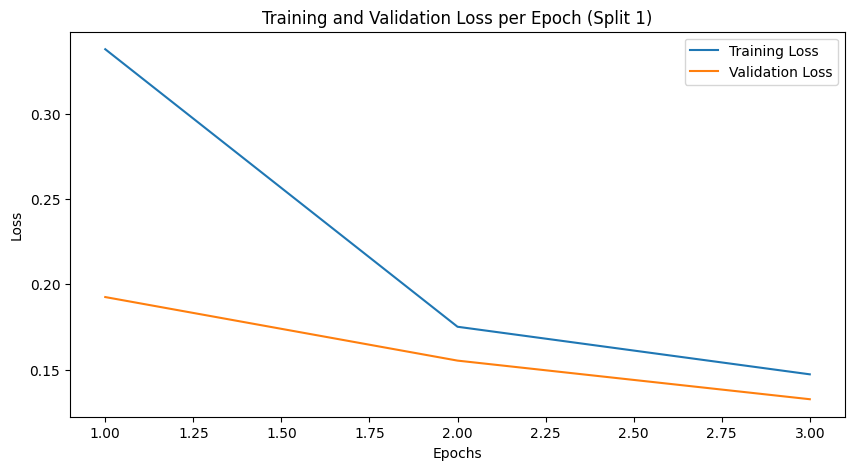

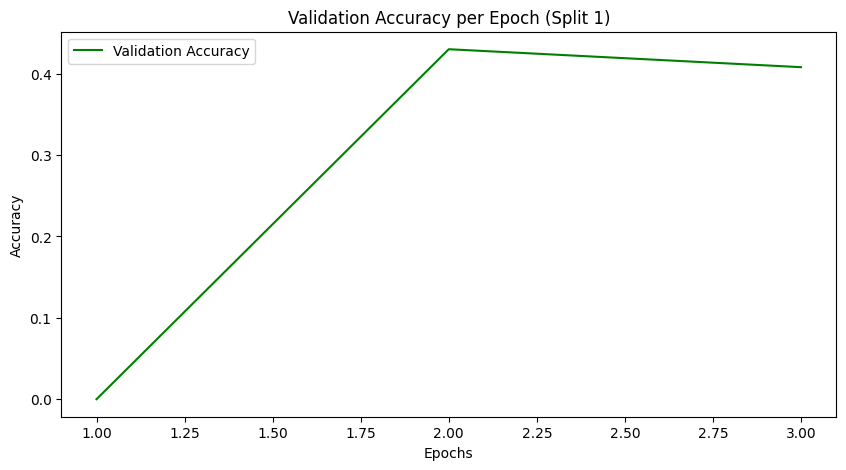

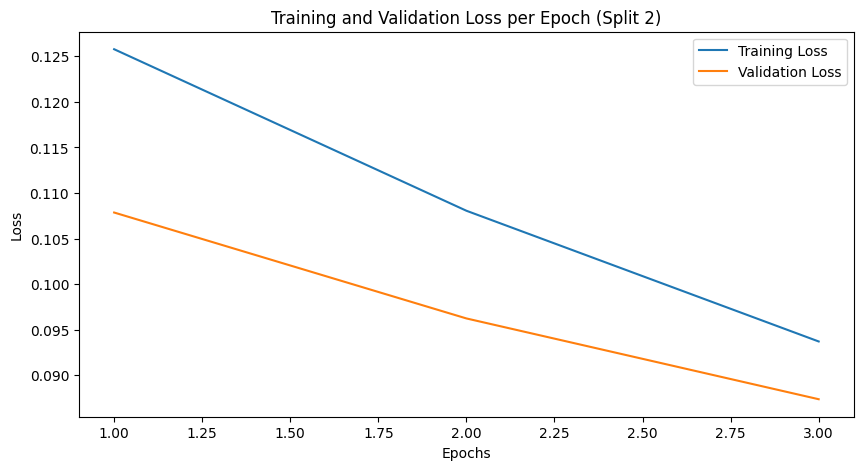

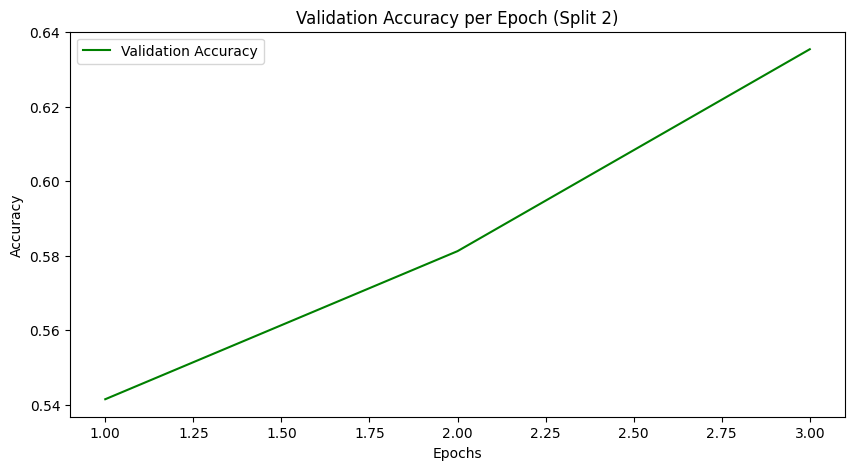

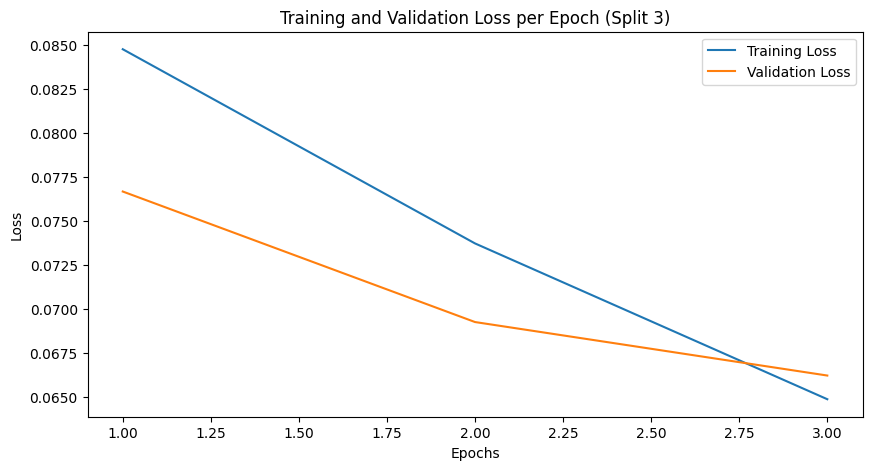

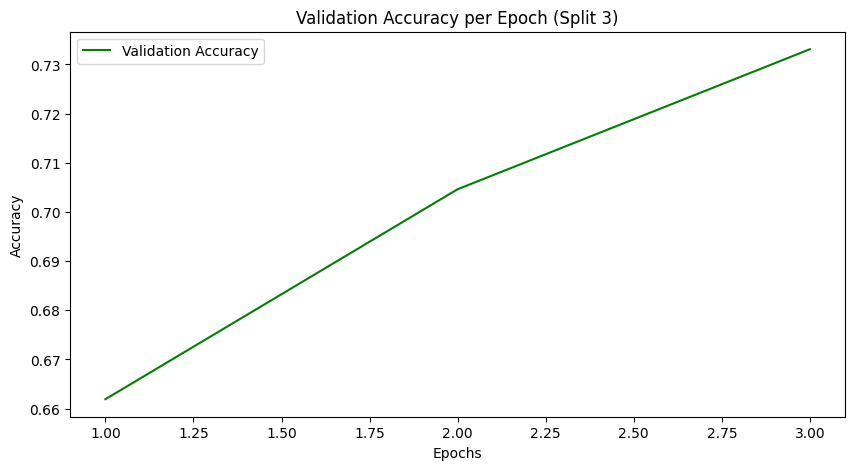

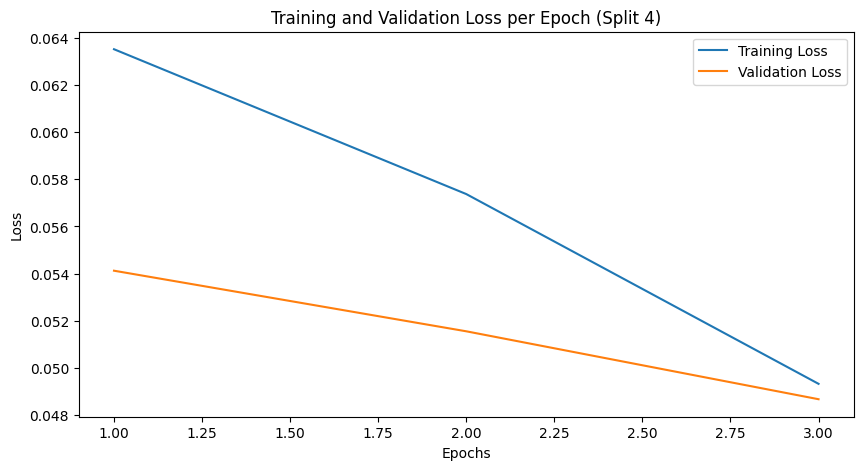

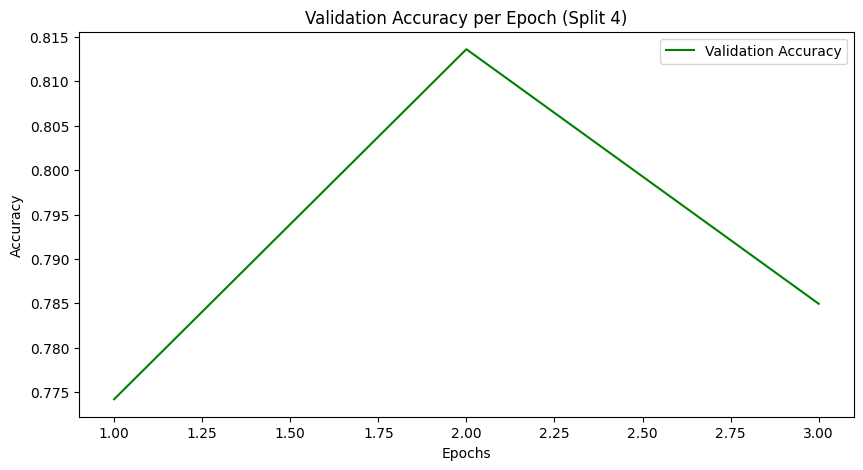

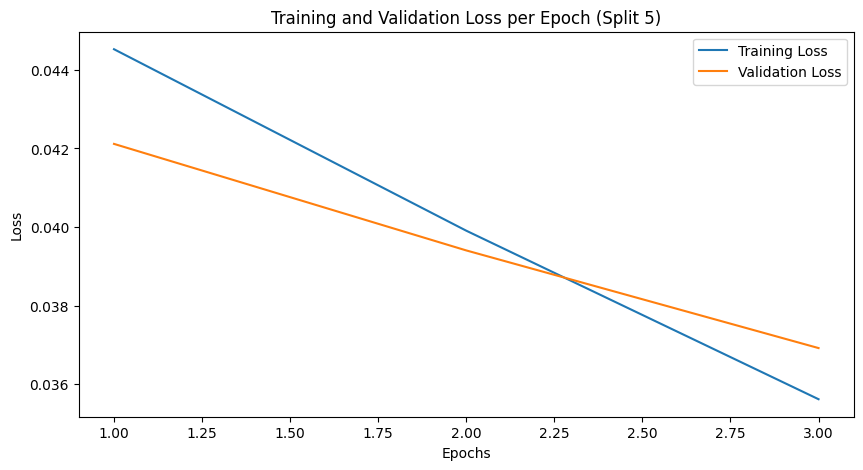

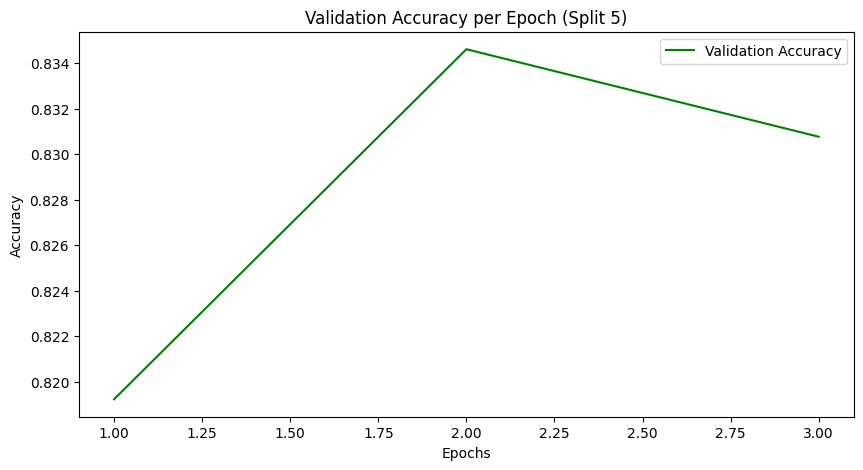

In [ ]:
for split_idx in range(n_splits):
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, all_train_losses[split_idx], label='Training Loss')
    plt.plot(epochs_range, all_val_losses[split_idx], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss per Epoch (Split {split_idx + 1})')
    plt.legend()
    plt.show()

    # Plot accuracy for each split
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, all_accuracies[split_idx], label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy per Epoch (Split {split_idx + 1})')
    plt.legend()
    plt.show()
